In [1]:
from ipynb.fs.full.functions import *  #if this command doesn't work, you first need to run 'pip install ipynb'

# Code for the "Analysing a two layer network..." report
This is a notebook that produces most of the plots shown in the report "Analysing a two layer network in a teacher-student framework using a gaussian covariate model" made by Oscar Bouverot-Dupuis in 2022. It trains the following neural network

$f_s(x)=\frac{1}{\sqrt{d}} w^T \cdot \sigma \left(\frac{F_s^T \cdot x}{\sqrt{d}}\right)$

with the layers $w \in \mathbb{R}^d$ and $F_s \in \mathbb{R}^{d \times d}$. The labels are generated according to the teacher

$f_t(x)=\frac{1}{\sqrt{d}} \theta^T \cdot \sigma \left(\frac{F_t^T \cdot x}{\sqrt{d}}\right)$

and the training is done with the following ridge regression loss

$\mathcal{L}(w,F_s|\{x^\mu\}_{\mu=[1...n]})=\sum_{\mu=1}^n \frac{1}{2} \left(f_s(x^\mu)-f_t(x^\mu)\right) ^2 + \frac{\lambda}{2}||w||^2$.

The following code outputs the trained layers and the performance estimators for selected regularisations `Lambda`, ratio `alpha`$=n/d$ and initialisation `init_type`. The code to plot this data ends this notebook.

#### 1. Parameter choice
Select the dimension `d`, the regularisations `Lambda`, ratio `alpha`$=n/d$, initialisation `init_type`, number of epochs `epochs` and wether or not the first layer $F_s$ should be frozen with `freeze_1st_layer`.

In [2]:
d=200
Lambda=[1,0.1,0.01,0.001]
alpha=[1,2]
init_type='planted'  #'planted' or 'random'
epochs =6000
freeze_1st_layer=False

#### 2. Initialisation parameter
We provide the initialisation layers used for the plots shown in the report. These only work for d=200. Feel free to try with other matrices.

In [3]:
#LOAD FIXED DATA FOR d=200
file=np.load('fixed_data.npz')
F_t=file['F_t']
theta=file['theta']
F_random=file['F_random']
theta_random=file['theta_random']

#### 3. Run the simulation
The dataset for a fixed sample number $n$ is always the same and is drawn with the seed $n$ (this gets rid of some randomness).

In [ ]:
Eg,Et,Loss,W,Fs,Loss_decay=train(d,Lambda,alpha,init_type,epochs,freeze_1st_layer,F_t,theta,F_random,theta_random)

To check if the network acheived convergence, the next plot is the loss decaying as a function of the epoch number.

In [ ]:
%matplotlib notebook
fig, axs=plt.subplots(len(Lambda),figsize=(7,2*len(Lambda)))
cmap = colors.LinearSegmentedColormap('custom', cdict, N=len(alpha))
for i in range(len(Lambda)):
    for j in range(len(alpha)):
        axs[i].plot(Loss_decay[i][j],c=cmap(j),label=r'$\alpha=$'+str(alpha[j]))
        axs[i].set_ylabel('$\lambda=$'+str(Lambda[i]))
plt.suptitle(f'Loss decay for $d=${d} and '+init_type+' initialisation')
axs[0].legend()

#### 4. Save the file if wanted
Don't forget to name the file.

In [ ]:
#SAVE FILE
np.savez('file_name',Lambda=Lambda,Eg=Eg,Et=Et,Loss=Loss,W=W,Fs=Fs)

To load a file, execute the following cell.

In [ ]:
#LOAD A FILE
file=np.load('file_name.npz')
Lambda=file['Lambda']
Eg=file['Eg']
Et=file['Et']
Loss=file['Loss']
W=file['W']
Fs=file['Fs']

#### 5. Plot the trained layers
The next two cells plot the second layer components and the first layer spectrum. This code only works if there are at leats two elements in `Lambda` (otherwise the subplot command fails).

In [ ]:
#Second layer plot
%matplotlib notebook
fig, axs=plt.subplots(len(Lambda),figsize=(7,2*len(Lambda)))
for i in range(len(Lambda)):
    for j in range(len(alpha)):
        axs[i].plot(W[i][j][0],'.',c=cmap(j),label=r'$\alpha=$'+str(alpha[j]))
        axs[i].set_ylabel('$\lambda=$'+str(Lambda[i]))
plt.suptitle(f'Second layer components for $d=${d} and '+init_type+' initialisation')
axs[0].legend()

In [ ]:
#First layer plot
%matplotlib notebook
fig, axs=plt.subplots(len(Lambda),figsize=(7,2*len(Lambda)))
for i in range(len(Lambda)):
    for j in range(len(alpha)):
        eig=np.abs(scipy.linalg.eigvals(Fs[i][j]))
        axs[i].plot(eig,c=cmap(j),label=r'$\alpha=$'+str(alpha[j]))
        axs[i].set_ylabel('$\lambda=$'+str(Lambda[i]))
plt.suptitle(f'First layer spectrum for $d=${d} and '+init_type+' initialisation')
axs[0].legend()

#### 6. Plot the performance estimators 
The next cell plots the generalisation error $\varepsilon_{gen.}$, the training error $\varepsilon_{train.}$ and the loss density $\ell$.

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(3, sharex=True, figsize=(8,10))
fig.suptitle(f'Performances for $d={d}$ and '+init_type+' initialisation')
cmap2 = colors.LinearSegmentedColormap('custom', cdict, N=len(Lambda))

for i in range(len(Lambda)):
    axs[0].loglog(alpha,Eg[i],'s--',c=cmap2(i),label='$\lambda = $'+str(Lambda[i]))
    axs[1].loglog(alpha,Et[i],'s--',c=cmap2(i))
    axs[2].loglog(alpha,Loss[i],'s--',c=cmap2(i))
plt.xlabel(r'$\alpha$',fontsize=15)
axs[0].set_ylabel(r'$\varepsilon_{gen.}$',fontsize=15)
axs[1].set_ylabel(r'$\varepsilon_{train.}$',fontsize=15)
axs[2].set_ylabel(r'$\ell$',fontsize=15)

axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=4)

#### 6. Gaussian covariate minimum
The next two cells compute a d plot the performances of the gaussian covariate model minimum derived in the report.

In [10]:
alpha_curve=np.logspace(-1,1.5,100)
n_g3m=d*np.array(alpha_curve)

def Loss_min(eta):
    F_test=F_t+eta*np.outer(theta,theta@F_t)/(theta@theta)
    _,_,l=g3m_prediction(d, np.array([n_train]), reg, F_test, F_t, theta, method='simple')
    return l

Eg_min,Et_min,L_min,Etas_min=[],[],[],[]
for reg in Lambda:
    eg_min,et_min,l_min,etas_min=[],[],[],[0]
    for n_train in n_g3m:
        eta_min=optimize.minimize(Loss_min,etas_min[-1], method='BFGS').x
        F_min=F_t+eta_min*np.outer(theta,theta@F_t)/(theta@theta)
        eg,et,l=g3m_prediction(d, np.array([n_train]), reg, F_min, F_t, theta, method='simple')
        eg_min.append(eg)
        et_min.append(et)
        l_min.append(l)
        etas_min.append(eta_min)
    Eg_min.append(eg_min)
    Et_min.append(et_min)
    L_min.append(l_min)
    Etas_min.append(np.array(etas_min[1:]))

<IPython.core.display.Javascript object>


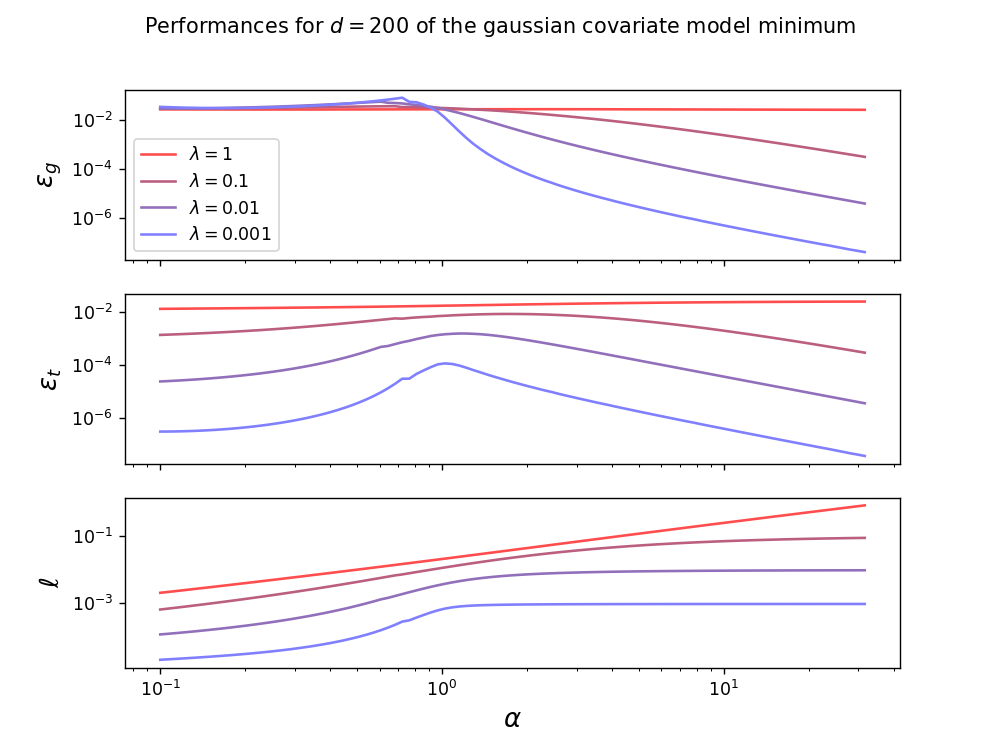

In [12]:
%matplotlib notebook
fig, axs = plt.subplots(3, sharex=True, figsize=(8,6))
fig.suptitle(f'Performances for $d={d}$ of the gaussian covariate model minimum')
cmap2 = colors.LinearSegmentedColormap('custom', cdict, N=len(Lambda))

for i in range(len(Lambda)):
    axs[0].loglog(alpha_curve,Eg_min[i],'-',c=cmap2(i),label='$\lambda = $'+str(Lambda[i]))
    axs[1].loglog(alpha_curve,Et_min[i],'-',c=cmap2(i))
    axs[2].loglog(alpha_curve,L_min[i],'-',c=cmap2(i))
plt.xlabel(r'$\alpha$',fontsize=15)
axs[0].set_ylabel(r'$\varepsilon_g$',fontsize=15)
axs[1].set_ylabel(r'$\varepsilon_t$',fontsize=15)
axs[2].set_ylabel(r'$\ell$',fontsize=15)

axs[0].legend()